In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import utils
from torch.utils.data import Dataset, DataLoader
from glob import glob
import time
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import datetime

print(torch.cuda.is_available())

True


# Create a Dataloader

In [2]:
IMAGE_W, IMAGE_H = 512, 256

In [3]:
class ImageDataset(Dataset):
    def __init__(self, train_val_test=0):
        self.train = train_val_test == 0
        self.images = glob(f"./new_ds/{['train', 'val', 'test'][train_val_test]}/*.png")
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.Normalize(mean=[0.28689554, 0.32513303, 0.28389177], 
                                             std=[0.18696375, 0.19017339, 0.18720214])
        ])
        
    def __len__(self):
        return len(self.images)       
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        # load and transform image
        img_pil = torchvision.io.read_image(img_path) / 255.
        
        return img_pil

In [4]:
img_ds = ImageDataset()
test_img = img_ds[4]

print(test_img.mean())
print(test_img.std())

tensor(0.2288)
tensor(0.1416)


In [5]:
# print(len(img_ds))

# t1 = time.time()

# for img in img_ds:
#     y = img
    
# print(f"Total time to go through ds: {time.time() - t1:.2f}s")

### Ground truth image

min: tensor(0.0392)
max: tensor(0.8078)
mean: tensor(0.2288)


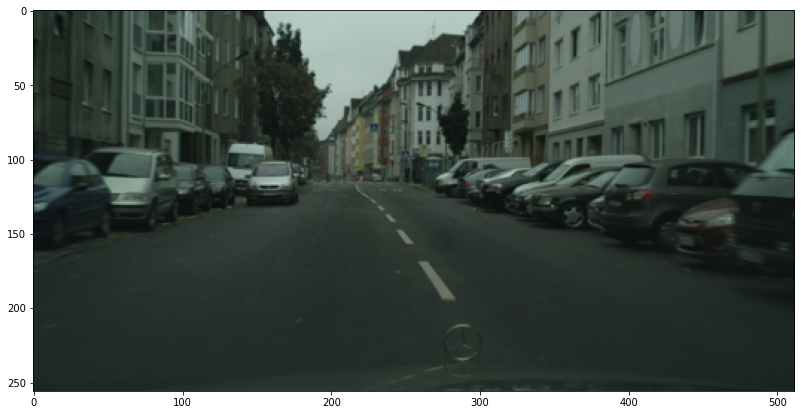

In [6]:
test_img = img_ds[4].unsqueeze(0)

print("min:", test_img.min())
print("max:", test_img.max())
print("mean:", test_img.mean())

plt.figure(figsize=(15, 7))
plt.imshow(test_img.squeeze(0).permute(1, 2, 0))

### Image with gaussian noise

In [7]:
def add_noise(x, std=0.1, device='cuda'):
    return x + torch.randn(x.size(), device=device) * std

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: tensor(-0.3226)
max: tensor(1.1438)
mean: tensor(0.2289)


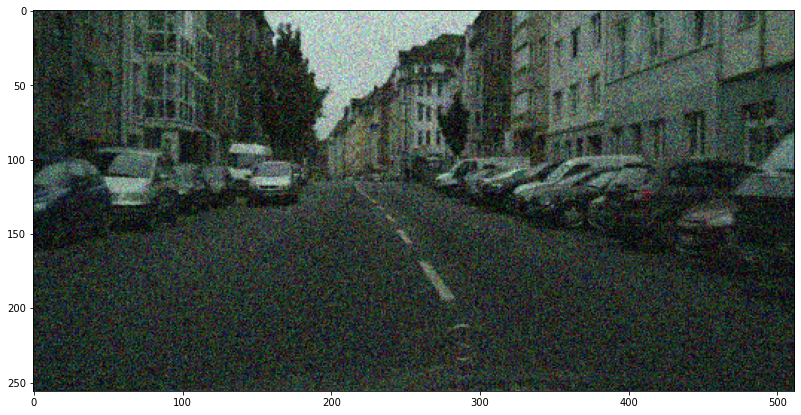

In [8]:
test_img = add_noise(img_ds[4].unsqueeze(0), device='cpu')

print("min:", test_img.min())
print("max:", test_img.max())
print("mean:", test_img.mean())

plt.figure(figsize=(15, 7))
plt.imshow(test_img.squeeze(0).permute(1, 2, 0))

# Create the model

In [9]:
# CURRENT: https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py
# https://medium.com/@tioluwaniaremu/vgg-16-a-simple-implementation-using-pytorch-7850be4d14a1

# State-of-the-art: https://paperswithcode.com/paper/mask-dino-towards-a-unified-transformer-based-1
 
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.ds = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True),     
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),  
        )
        self.init_weights()
    
    def init_weights(self):
        torch.nn.init.xavier_normal_(self.ds[0].weight, gain=torch.nn.init.calculate_gain(nonlinearity='conv2d'))
        torch.nn.init.xavier_normal_(self.ds[3].weight, gain=torch.nn.init.calculate_gain(nonlinearity='conv2d'))
        torch.nn.init.constant_(self.ds[0].bias, 0)
        torch.nn.init.constant_(self.ds[3].bias, 0)
        
    def forward(self, x):
        return self.ds(x)
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.us = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),     
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=2, stride=2),
        )
        self.init_weights()
        
    def init_weights(self):
        torch.nn.init.xavier_normal_(self.us[0].weight, gain=torch.nn.init.calculate_gain(nonlinearity='conv2d'))
        torch.nn.init.xavier_normal_(self.us[2].weight, gain=torch.nn.init.calculate_gain(nonlinearity='conv_transpose2d'))
        torch.nn.init.constant_(self.us[0].bias, 0)
        torch.nn.init.constant_(self.us[2].bias, 0)
        
    def forward(self, x):
        return self.us(x)
    
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return torch.clamp(x, 0, 1)

m = Model().cuda()

print(f"Original\t{test_img.shape}")
out = m(test_img.cuda())
print(f"Model out\t{out.shape}")

Original	torch.Size([1, 3, 256, 512])
Model out	torch.Size([1, 3, 256, 512])


In [10]:
summary(m, input_size=(3, 256, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 512]           1,792
         MaxPool2d-2         [-1, 64, 128, 256]               0
              ReLU-3         [-1, 64, 128, 256]               0
            Conv2d-4        [-1, 128, 128, 256]          73,856
              ReLU-5        [-1, 128, 128, 256]               0
           Encoder-6        [-1, 128, 128, 256]               0
            Conv2d-7         [-1, 64, 128, 256]          73,792
              ReLU-8         [-1, 64, 128, 256]               0
   ConvTranspose2d-9          [-1, 3, 256, 512]             771
          Decoder-10          [-1, 3, 256, 512]               0
Total params: 150,211
Trainable params: 150,211
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.50
Forward/backward pass size (MB): 230.00
Params size (MB): 0.57
Estimated

# Training Loop

In [11]:
BATCH_SIZE = 64
EPOCHS = 1000
LEARNING_RATE = 0.001

In [12]:
writer = SummaryWriter('runs/4194304_latent' + '_' + datetime.datetime.now().strftime("%d%m-%H%M%S"))

# initialize optimizer 
optim = torch.optim.Adam(m.parameters(), lr=LEARNING_RATE, amsgrad=True)

# dataloader 
dl_train = torch.utils.data.DataLoader(ImageDataset(train_val_test=0), batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# set up validation datasets and validation images
val_ds = ImageDataset(train_val_test=1)
dl_val = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

val_img1, val_img2, val_img3 = val_ds[14], val_ds[307], val_ds[450]

grid = torch.zeros((3, 256 * 2, 512 * 3))
grid[:, :256, 0:512] = val_img1
grid[:, :256, 512:512*2] = val_img2
grid[:, :256, 512*2:512*3] = val_img3

val_set = torch.stack((val_img1, val_img2, val_img3))

# loss function
criterion = torch.nn.MSELoss()

best_loss, patience = 10000, 0

noise_lvl = 0.1

for epoch in range(EPOCHS):
    loss_sum = 0
    t1 = time.time()
    m.train()
    for i, batch in enumerate(dl_train):
        # zero the gradient
        optim.zero_grad()
        # put the batch on GPU
        batch = batch.cuda()
        gt_batch = torch.clone(batch)
        # add noise to the input
        batch = add_noise(batch, std=noise_lvl)
        # forward pass
        out = m(batch)
        # calculate loss
        loss = criterion(out, gt_batch)
        # backward pass
        loss.backward()
        # gradient clipping
        nn.utils.clip_grad_value_(m.parameters(), 1)
        # update the weights
        optim.step()
        # add loss to loss sum
        loss_sum += loss.item()
    
    m.eval()
    
    with torch.no_grad():
        # validation and metric logging
        train_loss = loss_sum / len(dl_train)
        val_loss = 0
        
        # calculate validation loss
        for batch in dl_val:
            batch = batch.cuda()
            # forward pass
            out = m(batch)
            # calculate loss
            loss = criterion(out, batch)
            # add loss to loss sum
            val_loss += loss.item()
        
        # average the validation loss
        val_loss /= len(dl_val)
        # create validation images
        val_out = m(val_set.cuda())
    
        grid[:, 256:, 0:512] = torch.clamp(val_out[0], 0, 1)
        grid[:, 256:, 512:512*2] = torch.clamp(val_out[1], 0, 1)
        grid[:, 256:, 512*2:512*3] = torch.clamp(val_out[2], 0, 1)

        writer.add_image('images', grid, epoch)
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Val/train', val_loss, epoch)

        if val_loss < best_loss:
            best_loss = val_loss
            patience = 0
            torch.save(m.state_dict(), "models/4194304_latent.pt")
        else:
            patience += 1
           
        if patience == 5:
            noise_lvl = max(0, noise_lvl - 0.02)
        
        if patience == 15:
            print("No new best model achieved, stopping here.")
            break
        
        print(f"[{epoch + 1}/{EPOCHS}]\t({time.time() - t1:.2f}s)\tloss: {train_loss:.6f}\tval_loss: {val_loss:.6f}\tpatience: {patience}\tnoise: {noise_lvl}")

[1/1000]	(28.05s)	loss: 0.019864	val_loss: 0.010429	patience: 0	noise: 0.1
[2/1000]	(27.72s)	loss: 0.003014	val_loss: 0.003200	patience: 0	noise: 0.1
[3/1000]	(27.24s)	loss: 0.001816	val_loss: 0.001979	patience: 0	noise: 0.1
[4/1000]	(27.56s)	loss: 0.001338	val_loss: 0.001242	patience: 0	noise: 0.1
[5/1000]	(27.58s)	loss: 0.001090	val_loss: 0.000947	patience: 0	noise: 0.1
[6/1000]	(27.28s)	loss: 0.000946	val_loss: 0.000860	patience: 0	noise: 0.1
[7/1000]	(27.27s)	loss: 0.000869	val_loss: 0.000960	patience: 1	noise: 0.1
[8/1000]	(27.55s)	loss: 0.000817	val_loss: 0.000975	patience: 2	noise: 0.1
[9/1000]	(30.28s)	loss: 0.000784	val_loss: 0.001012	patience: 3	noise: 0.1
[10/1000]	(30.51s)	loss: 0.000771	val_loss: 0.000927	patience: 4	noise: 0.1
[11/1000]	(27.86s)	loss: 0.000744	val_loss: 0.000926	patience: 5	noise: 0.08
[12/1000]	(27.41s)	loss: 0.000614	val_loss: 0.000773	patience: 0	noise: 0.08
[13/1000]	(28.40s)	loss: 0.000583	val_loss: 0.000777	patience: 1	noise: 0.08
[14/1000]	(29.69s)

[104/1000]	(27.22s)	loss: 0.000079	val_loss: 0.000094	patience: 3	noise: 0
[105/1000]	(27.42s)	loss: 0.000077	val_loss: 0.000093	patience: 4	noise: 0
[106/1000]	(27.80s)	loss: 0.000078	val_loss: 0.000090	patience: 0	noise: 0
[107/1000]	(27.85s)	loss: 0.000079	val_loss: 0.000090	patience: 0	noise: 0
[108/1000]	(27.18s)	loss: 0.000078	val_loss: 0.000092	patience: 1	noise: 0
[109/1000]	(27.57s)	loss: 0.000076	val_loss: 0.000099	patience: 2	noise: 0
[110/1000]	(28.98s)	loss: 0.000078	val_loss: 0.000089	patience: 0	noise: 0
[111/1000]	(26.08s)	loss: 0.000077	val_loss: 0.000089	patience: 0	noise: 0
[112/1000]	(25.02s)	loss: 0.000074	val_loss: 0.000087	patience: 0	noise: 0
[113/1000]	(29.52s)	loss: 0.000074	val_loss: 0.000086	patience: 0	noise: 0
[114/1000]	(58.39s)	loss: 0.000076	val_loss: 0.000088	patience: 1	noise: 0
[115/1000]	(73.29s)	loss: 0.000073	val_loss: 0.000089	patience: 2	noise: 0
[116/1000]	(52.94s)	loss: 0.000074	val_loss: 0.000086	patience: 0	noise: 0
[117/1000]	(56.14s)	loss:

[214/1000]	(19.92s)	loss: 0.000054	val_loss: 0.000065	patience: 3	noise: 0
[215/1000]	(19.87s)	loss: 0.000056	val_loss: 0.000063	patience: 0	noise: 0
[216/1000]	(19.83s)	loss: 0.000057	val_loss: 0.000066	patience: 1	noise: 0
[217/1000]	(19.90s)	loss: 0.000056	val_loss: 0.000066	patience: 2	noise: 0
[218/1000]	(19.85s)	loss: 0.000055	val_loss: 0.000065	patience: 3	noise: 0
[219/1000]	(19.72s)	loss: 0.000054	val_loss: 0.000065	patience: 4	noise: 0
[220/1000]	(19.82s)	loss: 0.000054	val_loss: 0.000062	patience: 0	noise: 0
[221/1000]	(19.68s)	loss: 0.000056	val_loss: 0.000071	patience: 1	noise: 0
[222/1000]	(20.46s)	loss: 0.000057	val_loss: 0.000069	patience: 2	noise: 0
[223/1000]	(20.48s)	loss: 0.000054	val_loss: 0.000062	patience: 0	noise: 0
[224/1000]	(21.54s)	loss: 0.000054	val_loss: 0.000071	patience: 1	noise: 0
[225/1000]	(19.94s)	loss: 0.000053	val_loss: 0.000062	patience: 0	noise: 0
[226/1000]	(19.75s)	loss: 0.000053	val_loss: 0.000068	patience: 1	noise: 0
[227/1000]	(19.73s)	loss:

[324/1000]	(19.74s)	loss: 0.000047	val_loss: 0.000055	patience: 1	noise: 0
[325/1000]	(19.89s)	loss: 0.000049	val_loss: 0.000055	patience: 2	noise: 0
[326/1000]	(19.74s)	loss: 0.000049	val_loss: 0.000056	patience: 3	noise: 0
[327/1000]	(19.76s)	loss: 0.000050	val_loss: 0.000082	patience: 4	noise: 0
[328/1000]	(19.86s)	loss: 0.000055	val_loss: 0.000055	patience: 5	noise: 0
[329/1000]	(19.85s)	loss: 0.000046	val_loss: 0.000054	patience: 0	noise: 0
[330/1000]	(19.83s)	loss: 0.000046	val_loss: 0.000054	patience: 0	noise: 0
[331/1000]	(19.86s)	loss: 0.000047	val_loss: 0.000054	patience: 1	noise: 0
[332/1000]	(19.76s)	loss: 0.000048	val_loss: 0.000057	patience: 2	noise: 0
[333/1000]	(20.03s)	loss: 0.000047	val_loss: 0.000053	patience: 0	noise: 0
[334/1000]	(20.01s)	loss: 0.000047	val_loss: 0.000057	patience: 1	noise: 0
[335/1000]	(19.84s)	loss: 0.000046	val_loss: 0.000053	patience: 2	noise: 0
[336/1000]	(19.83s)	loss: 0.000046	val_loss: 0.000055	patience: 3	noise: 0
[337/1000]	(20.10s)	loss:

In [12]:
m.load_state_dict(torch.load("models/4194304_latent.pt"))

<All keys matched successfully>

In [49]:
m.encoder.ds

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
)

torch.Size([128, 1, 128, 256])


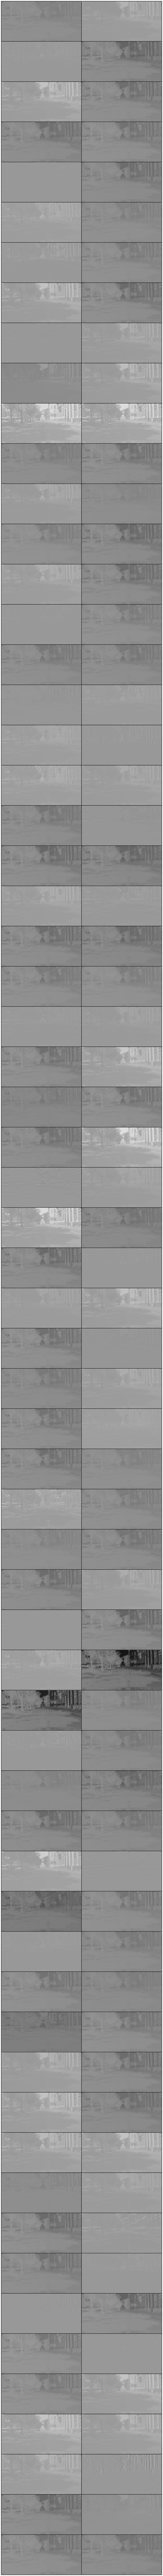

In [52]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow*10,rows*10) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

sequence = nn.Sequential(*[m.encoder.ds[x] for x in range(4)])
filter = sequence(img_ds[0].cuda()).detach().cpu().unsqueeze(1)
visTensor(filter, ch=0, nrow=2, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()